In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


### load packages

In [3]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [5]:
from tensorflow.keras.datasets import fashion_mnist

In [6]:
# load dataset
(train_images, Y_train), (test_images, Y_test) = fashion_mnist.load_data()
X_train = (train_images/255.).astype('float32')
X_test = (test_images/255.).astype('float32')
X_train = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

# subset a validation set
n_valid = 10000
X_valid = X_train[-n_valid:]
Y_valid = Y_train[-n_valid:]
X_train = X_train[:-n_valid]
Y_train = Y_train[:-n_valid]

# flatten X
X_train_flat = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test_flat = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
X_valid_flat= X_valid.reshape((len(X_valid), np.product(np.shape(X_valid)[1:])))
print(len(X_train), len(X_valid), len(X_test))

50000 10000 10000


In [7]:
from tfumap.paths import ensure_dir, MODEL_DIR

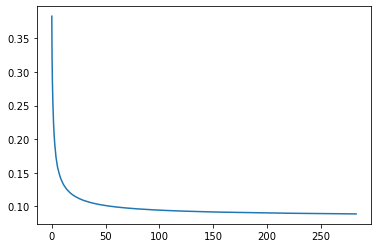

In [31]:
output_dir = MODEL_DIR/'projections'/ 'fmnist' / 'direct'
ensure_dir(output_dir)

loss_df_direct = pd.read_pickle(output_dir / 'loss_df.pickle')
loss_df_direct

plt.plot(loss_df_direct.wall_time - loss_df_direct.wall_time[0], loss_df_direct.val)

In [32]:
output_dir = MODEL_DIR/'projections'/ 'fmnist' / 'network'
ensure_dir(output_dir)

In [33]:
loss_df = pd.read_pickle(output_dir / 'loss_df.pickle')
loss_df

,wall_time,step,val,group,variable
0,1.594319e+09,1,5.242109,train,umap_loss
1,1.594319e+09,2,3.432908,train,umap_loss
2,1.594319e+09,3,2.488142,train,umap_loss
3,1.594319e+09,4,1.930092,train,umap_loss
4,1.594319e+09,5,1.576228,train,umap_loss
...,...,...,...,...,...
40395,1.594320e+09,40396,0.094158,train,umap_loss
40396,1.594320e+09,40397,0.094158,train,umap_loss
40397,1.594320e+09,40398,0.094157,train,umap_loss
40398,1.594320e+09,40399,0.094157,train,umap_loss


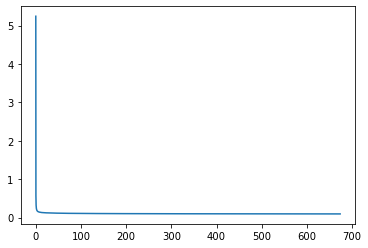

In [34]:
plt.plot(loss_df.wall_time - loss_df.wall_time[0], loss_df.val)

#### get umap learn

In [12]:
from umap import UMAP

In [13]:
embedder = UMAP(verbose=True)
z_umap = embedder.fit_transform(X_train_flat)

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Sat Aug 22 17:15:09 2020 Finding Nearest Neighbors
Sat Aug 22 17:15:09 2020 Building RP forest with 16 trees
Sat Aug 22 17:15:11 2020 parallel NN descent for 16 iterations
	 0  /  16
	 1  /  16
	 2  /  16
	 3  /  16
Sat Aug 22 17:15:21 2020 Finished Nearest Neighbor Search
Sat Aug 22 17:15:24 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Aug 22 17:15:54 2020 Finished embedding


In [14]:
from datetime import datetime

In [16]:
start_time = datetime.strptime('17:15:24', '%H:%M:%S')
end_time =   datetime.strptime('17:15:54', '%H:%M:%S') 
umap_learn_training_time = (end_time - start_time).total_seconds()
umap_learn_training_time

30.0

### compute loss for UMAP learn

In [17]:
embedder.graph_

<50000x50000 sparse matrix of type '<class 'numpy.float32'>'
	with 1130714 stored elements in Compressed Sparse Row format>

In [21]:
from tfumap.umap import get_graph_elements
graph, epochs_per_sample, head, tail, weight, n_vertices = get_graph_elements(
    embedder.graph_, embedder.n_epochs
)

In [22]:
max_sample_repeats_per_epoch = 25
batch_size = 1000
def batch_epoch_edges(edges_to, edges_from):
        """ permutes and batches edges for epoch
        """
        # compute the number of batches in one epoch
        n_batches = int(len(edges_to) / batch_size)
        # permute list of edges
        permutation_mask = np.random.permutation(len(edges_to))[
            : n_batches * batch_size
        ]
        to_all = tf.reshape(
            tf.gather(edges_to, permutation_mask), (n_batches, batch_size)
        )
        from_all = tf.reshape(
            tf.gather(edges_from, permutation_mask), (n_batches, batch_size)
        )
        # return a tensorflow dataset of one epoch's worth of batches
        return tf.data.Dataset.from_tensor_slices((to_all, from_all))
def create_edge_iterator(head, tail, weight):
        """ create an iterator for edges
        """
        # set the maximum number of times each edge should be repeated per epoch
        
        epochs_per_sample = np.clip(
            (weight / np.max(weight)) * max_sample_repeats_per_epoch,
            1,
            max_sample_repeats_per_epoch,
        ).astype("int")

        edges_to_exp, edges_from_exp = (
            np.array([np.repeat(head, epochs_per_sample.astype("int"))]),
            np.array([np.repeat(tail, epochs_per_sample.astype("int"))]),
        )
        edge_iter = tf.data.Dataset.from_tensor_slices((edges_to_exp, edges_from_exp))
        edge_iter = edge_iter.repeat()
        edge_iter = edge_iter.map(batch_epoch_edges)
        edge_iter = edge_iter.prefetch(buffer_size=10)

        return iter(edge_iter), np.shape(edges_to_exp)[1]

In [23]:
# create iterator for data/edges
edge_iter, n_edges_per_epoch = create_edge_iterator(head, tail, weight)

In [24]:
from tfumap.umap import convert_distance_to_probability, compute_cross_entropy
def compute_umap_loss(batch_to, batch_from):
        """
        compute the cross entropy loss for learning embeddings

        Parameters
        ----------
        batch_to : tf.int or tf.float32
            Either X or the index locations of the embeddings for verticies (to)
        batch_from : tf.int or tf.float32
            Either X or the index locations of the embeddings for verticies (from)

        Returns
        -------
        ce_loss : tf.float
            cross entropy loss for UMAP
        embedding_to : tf.float
            embeddings for verticies (to)
        embedding_from : tf.float
            embeddings for verticies (from)
        """

        # get the embeddings
        embedding_to = tf.gather(z_umap, batch_to)
        embedding_from = tf.gather(z_umap, batch_from)

        # get negative samples
        embedding_neg_to = tf.repeat(embedding_to, embedder.negative_sample_rate, axis=0)
        repeat_neg = tf.repeat(embedding_from, embedder.negative_sample_rate, axis=0)
        embedding_neg_from = tf.gather(
            repeat_neg, tf.random.shuffle(tf.range(tf.shape(repeat_neg)[0]))
        )

        #  distances between samples
        distance_embedding = tf.concat(
            [
                tf.norm(embedding_to - embedding_from, axis=1),
                tf.norm(embedding_neg_to - embedding_neg_from, axis=1),
            ],
            axis=0,
        )

        # convert probabilities to distances
        probabilities_distance = convert_distance_to_probability(
            distance_embedding, embedder._a, embedder._b
        )

        # treat positive samples as p=1, and negative samples as p=0
        probabilities_graph = tf.concat(
            [tf.ones(embedding_to.shape[0]), tf.zeros(embedding_neg_to.shape[0])],
            axis=0,
        )

        # cross entropy loss
        (attraction_loss, repellant_loss, ce_loss) = compute_cross_entropy(
            probabilities_graph,
            probabilities_distance,
            repulsion_strength=embedder.repulsion_strength,
        )

        return ce_loss, embedding_to, embedding_from

In [25]:
edge_epoch = next((iter(edge_iter)))

In [26]:
ce_loss_list = []
for batch_to, batch_from in tqdm(edge_epoch):
    (ce_loss, _, _) = compute_umap_loss(
                        batch_to, batch_from
                    )
    ce_loss_list.append(np.mean(ce_loss.numpy()))

In [27]:
umap_learn_loss = np.mean(ce_loss_list)
umap_learn_loss

0.090373404

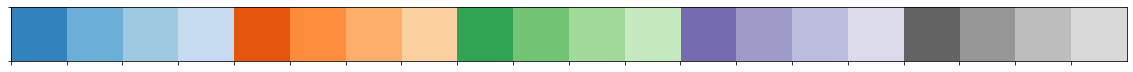

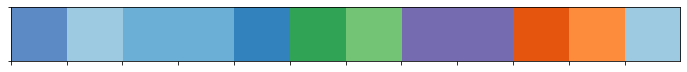

In [28]:
import seaborn as sns
pal20c = sns.color_palette('tab20c', 20)
sns.palplot(pal20c)
hue_dict = {
    "umap-learn": list(np.array(pal20c[3])**4),
    "direct": pal20c[2],
    "AE": pal20c[1],
    "autoencoder": pal20c[1],
    "network": pal20c[0],
    'vae':  pal20c[8], 
    'ae_only':  pal20c[9],
    "pca":  pal20c[12],
    "PCA":  pal20c[12],
    "TSNE": pal20c[4], 
    "parametric-tsne":pal20c[5],
    "network-cpu": pal20c[2],

}
sns.palplot([hue_dict[i] for i in hue_dict.keys()])

In [29]:
from tfumap.paths import FIGURE_DIR, save_fig

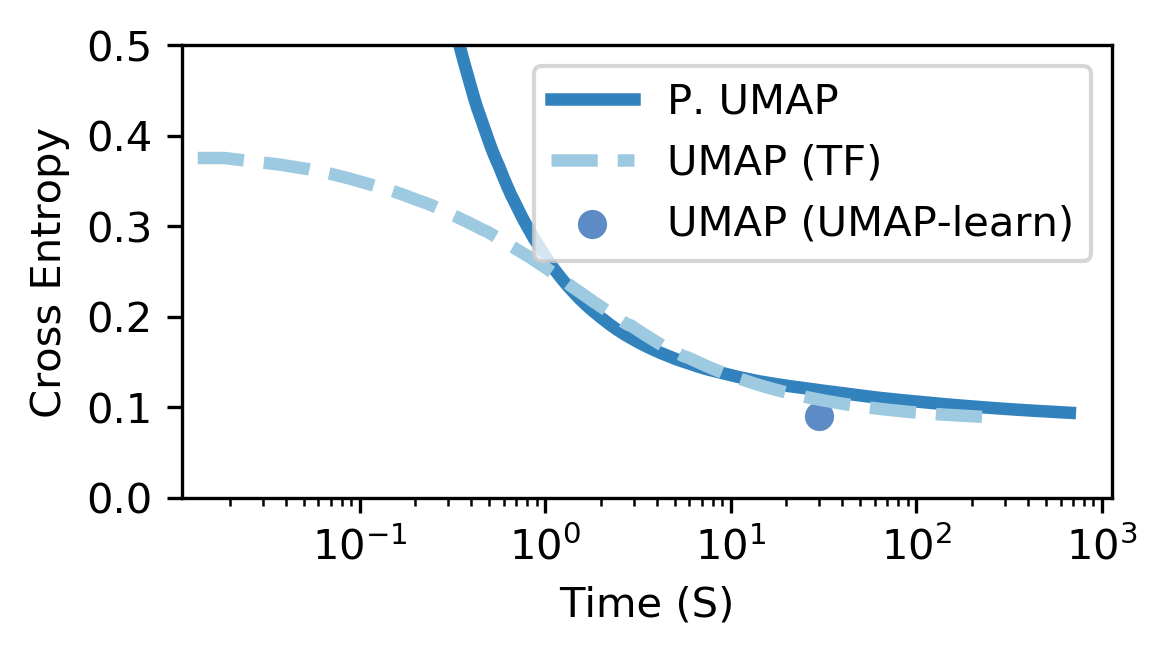

In [36]:
max_time = 1000#120
fig, ax = plt.subplots(figsize=(4,2), dpi=300)

time_d = loss_df.wall_time.values - loss_df.wall_time[0]
time_d_mask = time_d<max_time
val_d = loss_df.val.values[time_d_mask]
time_d = time_d[time_d_mask]
ax.plot(time_d,val_d, lw = 3, label='P. UMAP', color=hue_dict['network'])

time_d = loss_df_direct.wall_time.values - loss_df_direct.wall_time[0]
time_d_mask = time_d<max_time
val_d = loss_df_direct.val.values[time_d_mask]
time_d = time_d[time_d_mask]
ax.plot(time_d,val_d, lw = 3, label='UMAP (TF)', color=hue_dict['direct'], ls='dashed')

ax.scatter([umap_learn_training_time], umap_learn_loss, color=hue_dict['umap-learn'], label='UMAP (UMAP-learn)')
ax.set_ylim([0, 0.5])
ax.legend()
ax.set_ylabel('Cross Entropy')
ax.set_xlabel('Time (S)')
ax.set_xscale('log')
#ax.set_yscale('log')
save_fig(FIGURE_DIR/'fmnist-training-time', save_pdf=True, dpi=300)